/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Creating dummy images in 'imgs'...
  Saved: imgs/1_A_101.jpg (Class 0)
  Saved: imgs/1_A_102.jpg (Class 0)
  Saved: imgs/1_A_103.jpg (Class 0)
  Saved: imgs/1_A_104.jpg (Class 0)
  Saved: imgs/1_A_105.jpg (Class 0)
  Saved: imgs/1_BA_101.jpg (Class 1)
  Saved: imgs/1_BA_102.jpg (Class 1)
  Saved: imgs/1_BA_103.jpg (Class 1)
  Saved: imgs/1_BA_104.jpg (Class 1)
  Saved: imgs/1_BA_105.jpg (Class 1)
--- Starting Model Energy and Feature Analysis ---
Image 1 (imgs/1_A_101.jpg):
  Predicted Class: 409
  Prediction Entropy (Uncertainty): 5.3966 bits
Image 2 (imgs/1_A_102.jpg):
  Predicted Class: 409
  Prediction Entropy (Uncertainty): 5.3966 bits
Image 3 (imgs/1_A_103.jpg):
  Predicted Class: 409
  Prediction Entropy (Uncertainty): 5.3966 bits
Image 4 (imgs/1_A_104.jpg):
  Predicted Class: 409
  Prediction Entropy (Uncertainty): 5.3966 bits
Image 5 (imgs/1_A_105.jpg):
  Predicted Class: 409
  Prediction Entropy (Uncertainty): 5.3966 bits
Image 6 (imgs/1_BA_101.jpg):
  Predicted Class: 753
  

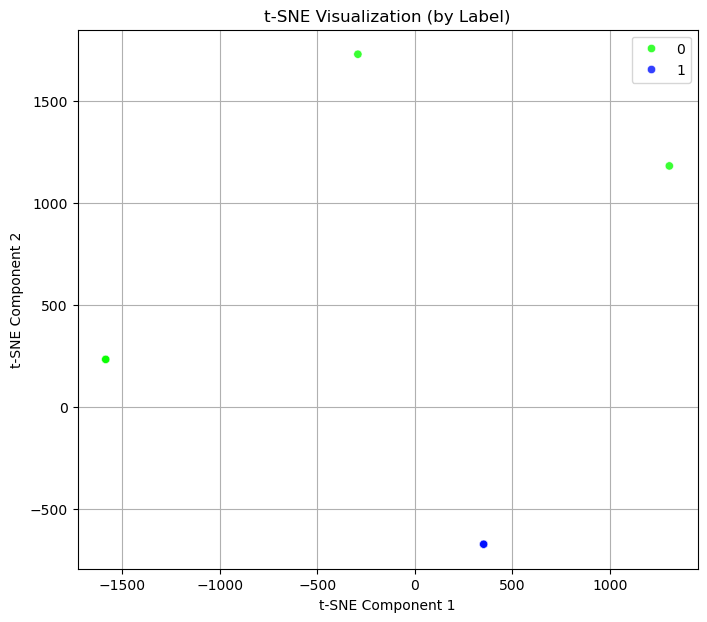

Average Prediction Entropy: 4.3289 bits

--- Analysis Complete ---

Final Analysis Results: {'silhouette_score': 1.0, 'avg_entropy': 4.328851}


In [7]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import captum.attr as attr # XAI 라이브러리 (Grad-CAM 등)
import os # 파일 경로 관리

# Plot 텍스트를 영어로만 표시하도록 설정 (한글 폰트 설정 제거)
# plt.rcParams['font.family'] = 'Malgun Gothic' # Removed for English only
plt.rcParams['axes.unicode_minus'] = True # Keep this for minus signs

# 가상 모델 (예: Pre-trained ResNet)
# 실제로는 YOLOvX 나 ViT 모델을 로드해야 합니다.
# 여기서는 예시를 위해 PyTorch의 ResNet을 사용하겠습니다.
model = models.resnet18(pretrained=True)
model.eval() # 평가 모드

# 이미지 전처리 파이프라인
# 32x32 그레이스케일 이미지를 ResNet 입력에 맞게 조정
preprocess = transforms.Compose([
    transforms.Resize(224), # ResNet은 224x224 입력을 기대합니다.
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3), # 그레이스케일 -> RGB 3채널로 변환
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class ModelEnergyAnalyzer:
    def __init__(self, model, feature_layer_name='avgpool'):
        self.model = model
        self.feature_layer_name = feature_layer_name
        self.features = None
        self.feature_layer_hook = None # Hook 객체를 저장하여 나중에 제거할 수 있도록

        self._register_feature_hook()

    def _register_feature_hook(self):
        # 특정 레이어의 특징 벡터를 추출하기 위한 훅(hook) 설정
        target_module = None
        for name, module in self.model.named_modules():
            if name == self.feature_layer_name:
                target_module = module
                break

        if target_module is None:
            raise ValueError(f"Layer '{self.feature_layer_name}' not found in the model.")

        # 훅 등록: self.features에 레이어의 출력을 저장
        self.feature_layer_hook = target_module.register_forward_hook(self._save_features_hook)

    def _save_features_hook(self, module, input, output):
        # ResNet의 avgpool 출력은 (Batch, Channel, 1, 1) 형태이므로, 1,1 차원을 제거
        # ViT의 경우 [CLS] 토큰 임베딩은 (Batch, Dim) 형태일 수 있음
        self.features = output.squeeze().detach().cpu().numpy()

    def _remove_feature_hook(self):
        if self.feature_layer_hook:
            self.feature_layer_hook.remove()

    def _get_features(self, image_tensor):
        self.features = None # Clear previous features
        with torch.no_grad():
            _ = self.model(image_tensor)
        return self.features # self._save_features_hook에 의해 채워짐

    def analyze(self, image_paths, labels=None):
        results = {}
        all_features_list = [] # 리스트로 먼저 저장하여 길이 불일치 오류 방지
        all_predictions = []
        valid_labels = [] # 유효하게 처리된 이미지의 레이블만 저장

        print("--- Starting Model Energy and Feature Analysis ---")

        for i, img_path in enumerate(image_paths):
            try:
                img = Image.open(img_path).convert('RGB') # ResNet expects RGB
                img_tensor = preprocess(img).unsqueeze(0) # Add batch dimension

                # 1. Feature extraction
                features = self._get_features(img_tensor)

                if features is not None:
                    # Check if features is an array, then flatten
                    if features.ndim > 0:
                        all_features_list.append(features.flatten())
                    else: # If it's a scalar value
                        all_features_list.append(np.array([features])) # Make it a 1D array

                # 2. Prediction and Uncertainty (Entropy) calculation
                with torch.no_grad():
                    outputs = self.model(img_tensor)
                    probabilities = F.softmax(outputs, dim=1).squeeze().numpy()
                    predicted_class = np.argmax(probabilities)
                    # Calculate prediction entropy
                    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-9)) # log2 for bits
                    all_predictions.append({'predicted_class': predicted_class, 'entropy': entropy})

                print(f"Image {i+1} ({img_path}):")
                print(f"  Predicted Class: {predicted_class}")
                print(f"  Prediction Entropy (Uncertainty): {entropy:.4f} bits")

                # Add label only if processed without error
                if labels is not None and i < len(labels):
                    valid_labels.append(labels[i])

                # Grad-CAM (XAI) example (commented out by default)
                # Ensure captum is installed and target_tensor type is correct
                # if torch.cuda.is_available():
                #     img_tensor = img_tensor.to('cuda')
                #     self.model.to('cuda')
                # from captum.attr import GuidedBackprop
                # gbp = GuidedBackprop(self.model)
                # target_tensor = torch.tensor(predicted_class, device=img_tensor.device)
                # attributions = gbp.attribute(img_tensor, target=target_tensor)
                # print(f"  Grad-CAM (Guided Backprop) attributions calculated (if Captum enabled).")


            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue # Skip sample if an error occurs

        # Convert all_features_list to a NumPy array after processing all images
        if not all_features_list:
            print("No valid images processed.")
            return {}

        # Check for length consistency (still a potential point of failure if feature dimensions vary greatly)
        # For ResNet avgpool, this should not be an issue.
        # If lengths differ, you might need padding/truncation here.
        all_features = np.array(all_features_list)


        # 3. Latent Space Clustering Stability (Silhouette Score - if labels are available)
        # Calculate only if enough valid data/labels
        if len(valid_labels) > 1 and len(np.unique(valid_labels)) > 1 and len(valid_labels) == len(all_features):
            try:
                silhouette_avg = silhouette_score(all_features, valid_labels)
                print(f"\nLatent Space Silhouette Score (Clustering Stability): {silhouette_avg:.4f}")
                results['silhouette_score'] = silhouette_avg
            except Exception as e:
                print(f"Error calculating Silhouette Score: {e} (Occurs if less than 2 clusters or insufficient samples)")
        else:
            print("\nInsufficient valid data/labels for Silhouette Score calculation.")

        # 4. Latent Space Visualization (t-SNE)
        # Requires at least 2 samples for t-SNE
        if len(all_features) >= 2:
            print("\nVisualizing Latent Space (t-SNE)...")
            # Perplexity must be less than the number of samples.
            perplexity_val = min(30, len(all_features) - 1)
            if perplexity_val <= 0:
                print("Insufficient number of samples for t-SNE visualization.")
            else:
                tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val)
                transformed_features = tsne.fit_transform(all_features)

                plt.figure(figsize=(8, 7))
                if valid_labels and len(np.unique(valid_labels)) > 1:
                    sns.scatterplot(
                        x=transformed_features[:, 0], y=transformed_features[:, 1],
                        hue=valid_labels, palette=sns.color_palette("hsv", len(np.unique(valid_labels))),
                        legend="full", alpha=0.8
                    )
                    plt.title('t-SNE Visualization (by Label)')
                else:
                    sns.scatterplot(
                        x=transformed_features[:, 0], y=transformed_features[:, 1],
                        alpha=0.8
                    )
                    plt.title('t-SNE Visualization (No Labels)')
                plt.xlabel('t-SNE Component 1')
                plt.ylabel('t-SNE Component 2')
                plt.grid(True)
                plt.show()
        else:
            print("\nInsufficient valid samples for t-SNE visualization.")


        avg_entropy_val = np.mean([p['entropy'] for p in all_predictions]) if all_predictions else 0
        results['avg_entropy'] = avg_entropy_val
        print(f"Average Prediction Entropy: {avg_entropy_val:.4f} bits")

        print("\n--- Analysis Complete ---")
        return results

# --- Usage Example ---
if __name__ == "__main__":
    # 1. Create dummy images in 'imgs' directory for testing
    dummy_image_dir = 'imgs' # Use the specified directory name
    os.makedirs(dummy_image_dir, exist_ok=True)

    # Provided sample image paths and labels
    sample_image_paths = [
        "imgs/1_A_101.jpg",
        "imgs/1_A_102.jpg",
        "imgs/1_A_103.jpg",
        "imgs/1_A_104.jpg",
        "imgs/1_A_105.jpg",
        "imgs/1_BA_101.jpg",
        "imgs/1_BA_102.jpg",
        "imgs/1_BA_103.jpg",
        "imgs/1_BA_104.jpg",
        "imgs/1_BA_105.jpg",
    ]
    sample_labels = [
        0, 0, 0, 0, 0, # Class 0 for 'A' patterns
        1, 1, 1, 1, 1, # Class 1 for 'BA' patterns
    ]

    # Generate dummy images based on the provided paths
    print(f"Creating dummy images in '{dummy_image_dir}'...")
    for path, label in zip(sample_image_paths, sample_labels):
        img_data = np.zeros((32, 32), dtype=np.uint8)
        if label == 0: # Class 0: e.g., diagonal pattern
            for i in range(32):
                img_data[i, i] = 200
                img_data[i, 31-i] = 200
        else: # Class 1: e.g., horizontal stripes
            for i in range(0, 32, 4): # Create stripes every 4 rows
                img_data[i:i+2, :] = 200
        
        # Ensure parent directory exists for the image path
        parent_dir = os.path.dirname(path)
        if parent_dir and not os.path.exists(parent_dir):
            os.makedirs(parent_dir, exist_ok=True)
            
        Image.fromarray(img_data).save(path)
        print(f"  Saved: {path} (Class {label})")

    # 2. Initialize Model Analyzer
    # Using ResNet18's 'avgpool' layer for features.
    # If using YOLO, ViT, load the appropriate model and specify the correct feature_layer_name.
    analyzer = ModelEnergyAnalyzer(model=model, feature_layer_name='avgpool')

    # 3. Run Analysis
    analysis_results = analyzer.analyze(sample_image_paths, sample_labels)
    print("\nFinal Analysis Results:", analysis_results)

    # Remove the hook when done (optional but good practice)
    analyzer._remove_feature_hook()